# Intialize

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy_sz import Class
import os
import time




# the parameters needed for cosmology:
# use the last column of Planck 2018 (https://arxiv.org/pdf/1807.06209.pdf)
# TT,TE,EE+lowE+lensing+BAO
cosmo_params = {
'omega_b': 0.02242,
'omega_cdm':  0.11933,
'H0': 67.66,
'tau_reio': 0.0561,
'ln10^{10}A_s': 3.047,
'n_s': 0.9665,

'k_pivot': 0.05,
'N_ncdm': 1,
'N_ur': 2.0328,
'm_ncdm': 0.06    

}




common_params = {

'z_min' : 0.005,
'z_max' : 3.0,
'M_min' : 1.0e10, 
'M_max' : 3.5e15,
    

'delta for galaxies' : "200c",
'delta for matter density' : "200c",
'delta for electron density':"200c",    

'mass function' : 'T08M200c',
'concentration parameter' : 'B13',

'redshift_epsabs': 1.0e-40,
'redshift_epsrel': 0.0005,
'mass_epsabs': 1.0e-40,
'mass_epsrel': 0.0005,


'ell_max': 1600.0,
'ell_min': 2.0,
'dell': 10,

'non_linear' : 'hmcode',
'pk_nonlinear_for_vrms2' : 1,
'hm_consistency' : 1,
    
'f_free' : 1.0,
    

# 'ndim_masses': 150,
# 'ndim_redshifts': 150,

# 'P_k_max_h/Mpc': 50.0,
# 'k_min_for_pk_class_sz': 0.0001,
# 'k_max_for_pk_class_sz': 10.0,
# 'k_per_decade_class_sz': 20.0,
    
'x_out_truncated_nfw_profile':1.,
'x_out_truncated_density_profile (electrons)': 1., 
'use_xout_in_density_profile_from_enclosed_mass': 1,
'normalize_gas_density_profile': 0, # only useful when we dont set xout_in_density_profile_from_enclosed_mass, e.g., computing the transform as in Cayuso et al 2021 
    
# 'ksz template file': path_to_kSZ2X_2022+'external_data/dl_ksz_hm_agn_1p2h_uK2_170422.txt',
# 'ksz template file, reio contribution': path_to_kSZ2X_2022+'external_data/dl_ksz_hm_agn_1p2h_uK2_170422_zeros.txt',

# for the truncation of the pressure profile important!
'x_outSZ': 4.,
'truncate_wrt_rvir':0,
}

Metal device set to: Apple M1 Pro


2023-02-26 15:26:06.893309: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-26 15:26:06.893409: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Density

## The profile

In [2]:
%%time
M = Class()
M.set(cosmo_params)
M.set({
# class_sz parameters:
'output':'m200m_to_m200c,m200c_to_m200m,m200c_to_m500c',

'tabulate_rhob_xout_at_m_and_z': 1,
'gas profile':'B16',
'gas profile mode' : 'custom',
    
# # Amodeo et al profile setup:
# "A_rho0": 10**2.8,
# "A_alpha": 1.,
# "A_beta": 2.6,

# "alpha_m_rho0": 0.,
# "alpha_m_alpha": 0.,
# "alpha_m_beta": 0.,

# "alpha_z_rho0": 0.,
# "alpha_z_alpha": 0.,
# "alpha_z_bet": 0.,
# "gamma_B16": -0.2,
# "xc_B16": 0.6,
        })
M.compute()

CPU times: user 18.5 s, sys: 73.1 ms, total: 18.6 s
Wall time: 2.4 s


In [3]:
# chose a mass and redshift for a given halo of interest
# amodeo et al: m = 3e13 Msun/h at z=0.55
z = 0.25
# m200m = 3e14
# convert to 200c for b16 profile
m200c = 3.3e13*M.h()#M.get_m200m_to_m200c_at_z_and_M(z,m200m)
m200m = M.get_m200c_to_m200m_at_z_and_M(z,m200c)


lambda_min = 0.1
lambda_max = 200
n_lambda = 500
lambda_array = np.geomspace(lambda_min,lambda_max,n_lambda)

# store the radial profiles of the gas
rho_gas_nfw = np.vectorize(M.get_gas_profile_at_x_M_z_nfw_200c)
rho_gas_b16 = np.vectorize(M.get_gas_profile_at_x_M_z_b16_200c)

# normalized radial array for b16:
x_200c = lambda_array

# dimensonfull radial array:
r200c = M.get_r_delta_of_m_delta_at_z(200,m200c,z)
r = x_200c*r200c
theta_arcmin = M.get_rad_to_arcmin(r/M.get_dA(z))

# normalized radial array for nfw:
r200m = M.get_r_delta_of_m_delta_at_z(200*M.Om_m(z),m200m,z)
c200m = M.get_c200m_at_m_and_z_D08(m200m,z)
c200c = M.get_c200c_at_m_and_z_D08(m200c,z)
rs_200m = r200m/c200m
xs_200m =  r/rs_200m
rs_200c = r200c/c200c
xs_200c=  r/rs_200c

def x200c_to_theta_arcmin(X):
    return M.get_rad_to_arcmin(r200c*X/M.get_dA(z))
def theta_arcmin_to_x200c(X):
    theta_rad = M.get_arcmin_to_rad(X)
    r = M.get_dA(z)*theta_rad
    return r/r200c

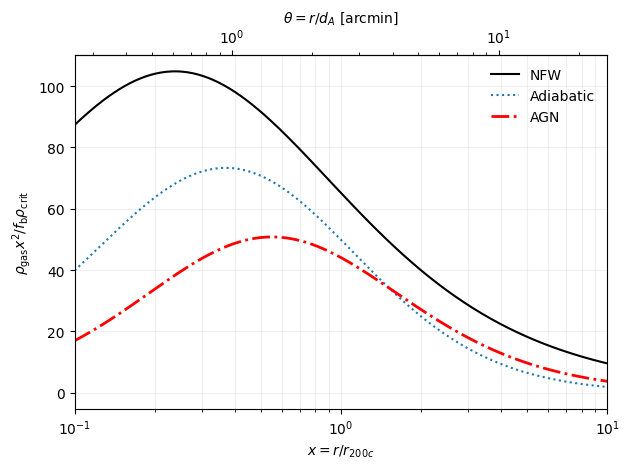

In [4]:
fig = plt.figure()
ax1 = fig.add_subplot(111)


rho_norm_nfw = rho_gas_nfw(xs_200c,m200c,z)/M.get_rho_crit_at_z(z)/M.get_f_b()
ax1.plot(x_200c,rho_norm_nfw*x_200c**2,label = 'NFW',c='k')


# rhos_over_rhocz = 1./3.*200.*c200c**3.*(np.log(1.+c200c)-c200c/(1.+c200c))**-1.
# A_rho0 = 1.
# A_alpha = 1.#rhos_over_rhocz
# A_beta = 3.
# alpha_m_rho0 = 0.
# alpha_m_alpha = 0.
# alpha_m_beta = 0.
# alpha_z_rho0 = 0.
# alpha_z_alpha = 0.
# alpha_z_beta = 0.
# gamma = -1.
# xc = 1./c200c

# # gammas = [-0.1,-0.2,-0.3]
# gammas = [-1.]

# rho_norm_b16 = rho_gas_b16(x_200c,
#                            m200c,
#                            z,
#                            A_rho0=A_rho0_norm(
#                                             A_rho0=A_rho0,
#                                             A_alpha=A_alpha,
#                                             A_beta=A_beta,
#                                             alpha_m_rho0 = alpha_m_rho0,
#                                             alpha_m_alpha = alpha_m_alpha,
#                                             alpha_m_beta = alpha_m_beta,
#                                             alpha_z_rho0 = alpha_z_rho0,
#                                             alpha_z_alpha = alpha_z_alpha,
#                                             alpha_z_beta = alpha_z_beta,
#                                             gamma=gamma,
#                                             xc = xc
#                                              ),
# #                                 A_rho0=rhos_over_rhocz,
#                             A_alpha = A_alpha,
#                             A_beta = A_beta,
#                             alpha_m_rho0 = alpha_m_rho0,
#                             alpha_m_alpha = alpha_m_alpha,
#                             alpha_m_beta = alpha_m_beta,
#                             alpha_z_rho0 = alpha_z_rho0,
#                             alpha_z_alpha = alpha_z_alpha,
#                             alpha_z_beta = alpha_z_beta,
#                             gamma=gamma,
#                             xc = xc)/M.get_rho_crit_at_z(z)/M.get_f_b()
# ax1.plot(x_200c,rho_norm_b16*x_200c**2, label = r'B16 NFW-like',ls='--')


A_rho0 = 1.9e4
A_alpha = 0.70
A_beta = 4.43

alpha_m_rho0 = 0.09
alpha_m_alpha = -0.017
alpha_m_beta = 0.005

alpha_z_rho0 = -0.95
alpha_z_alpha = 0.27
alpha_z_beta = 0.037
gamma = -0.2
xc = 0.5

rho_norm_b16 = rho_gas_b16(x_200c,
                           m200c,
                           z,
                           A_rho0 = A_rho0,
#                            A_rho0=A_rho0_norm(
#                                             A_rho0=A_rho0,
#                                             A_alpha=A_alpha,
#                                             A_beta=A_beta,
#                                             alpha_m_rho0 = alpha_m_rho0,
#                                             alpha_m_alpha = alpha_m_alpha,
#                                             alpha_m_beta = alpha_m_beta,
#                                             alpha_z_rho0 = alpha_z_rho0,
#                                             alpha_z_alpha = alpha_z_alpha,
#                                             alpha_z_beta = alpha_z_beta,
#                                             gamma=gamma,
#                                             xc = xc
#                                              ),
#                                 A_rho0=rhos_over_rhocz,
                            A_alpha = A_alpha,
                            A_beta = A_beta,
                            alpha_m_rho0 = alpha_m_rho0,
                            alpha_m_alpha = alpha_m_alpha,
                            alpha_m_beta = alpha_m_beta,
                            alpha_z_rho0 = alpha_z_rho0,
                            alpha_z_alpha = alpha_z_alpha,
                            alpha_z_beta = alpha_z_beta,
                            gamma=gamma,
                            xc = xc)/M.get_rho_crit_at_z(z)/M.get_f_b()
ax1.plot(x_200c,rho_norm_b16*x_200c**2, label = r'Adiabatic',ls=':')




A_rho0 = 4.e3
A_alpha = 0.88
A_beta = 3.83

alpha_m_rho0 = 0.29
alpha_m_alpha = -0.03
alpha_m_beta = 0.04

alpha_z_rho0 = -0.66
alpha_z_alpha = 0.19
alpha_z_beta = -0.025
gamma = -0.2
xc = 0.5

rho_norm_b16 = rho_gas_b16(x_200c,
                           m200c,
                           z,
                           A_rho0 = A_rho0,
#                            A_rho0=A_rho0_norm(
#                                             A_rho0=A_rho0,
#                                             A_alpha=A_alpha,
#                                             A_beta=A_beta,
#                                             alpha_m_rho0 = alpha_m_rho0,
#                                             alpha_m_alpha = alpha_m_alpha,
#                                             alpha_m_beta = alpha_m_beta,
#                                             alpha_z_rho0 = alpha_z_rho0,
#                                             alpha_z_alpha = alpha_z_alpha,
#                                             alpha_z_beta = alpha_z_beta,
#                                             gamma=gamma,
#                                             xc = xc
#                                              ),
#                                 A_rho0=rhos_over_rhocz,
                            A_alpha = A_alpha,
                            A_beta = A_beta,
                            alpha_m_rho0 = alpha_m_rho0,
                            alpha_m_alpha = alpha_m_alpha,
                            alpha_m_beta = alpha_m_beta,
                            alpha_z_rho0 = alpha_z_rho0,
                            alpha_z_alpha = alpha_z_alpha,
                            alpha_z_beta = alpha_z_beta,
                            gamma=gamma,
                            xc = xc)/M.get_rho_crit_at_z(z)/M.get_f_b()
ax1.plot(x_200c,rho_norm_b16*x_200c**2, label = r'AGN',ls='-.',c='r',lw=2.)




ax1.set_xscale('log')
ax1.legend(frameon=False)
ax1.set_xlabel(r'$x=r/r_{200c}$')
ax1.set_ylabel(r'$\rho_\mathrm{gas}x^2/f_\mathrm{b}\rho_\mathrm{crit}$')

plt.grid(which='both',alpha=0.2)
secax = ax1.secondary_xaxis('top', functions=(x200c_to_theta_arcmin, theta_arcmin_to_x200c))

secax.set_xlabel(r'$\theta = r/d_A$ [arcmin]')
# ax1.set_ylim(1e1,1e2)
ax1.set_xlim(1e-1,1e1)

fig.tight_layout()
# plt.savefig(path_to_kSZ2X_2022+'prof_comp.pdf')



## The power spectrum

In [5]:
%%time
z_for_pk_hm = 1.

M = Class()
# M.set(ksz_params)
M.set(common_params)
M.set(cosmo_params)
M.set({

'output': 'mPk,pk_at_z_1h,pk_at_z_2h,pk_bb_at_z_1h,pk_bb_at_z_2h',
'gas profile':'B16',
'gas profile mode' : 'shock',


'x_out_truncated_density_profile (electrons)': 1., 
'normalize_gas_density_profile' : 0,
'use_xout_in_density_profile_from_enclosed_mass' : 1,
    


"dlnk_for_pk_hm" : 0.1,
"z_for_pk_hm" : z_for_pk_hm,
"z_pk" : z_for_pk_hm ,
"k_min_for_pk_hm" : 1e-3,
"k_max_for_pk_hm" : 5e1,
    
})



M.compute()
pk_at_z_hm = M.pk_at_z_hm()
pk_at_z_class_halofit = np.vectorize(M.pk)
pk_bb_at_z_hm_shock = M.pk_bb_at_z_hm()


M = Class()
# M.set(ksz_params)
M.set(common_params)
M.set(cosmo_params)
M.set({

'output': 'mPk,pk_at_z_1h,pk_at_z_2h,pk_bb_at_z_1h,pk_bb_at_z_2h',
    
'gas profile':'B16',
'gas profile mode' : 'shock',


'x_out_truncated_density_profile (electrons)': 1., 
'normalize_gas_density_profile' : 0,
'use_xout_in_density_profile_from_enclosed_mass' : 1,
    
'hm_consistency' : 0,

"dlnk_for_pk_hm" : 0.1,
"z_for_pk_hm" : z_for_pk_hm,
"z_pk" : z_for_pk_hm ,
"k_min_for_pk_hm" : 1e-3,
"k_max_for_pk_hm" : 5e1,
    
})



M.compute()
pk_at_z_hm_no_consistency = M.pk_at_z_hm()

M = Class()
# M.set(ksz_params)
M.set(common_params)
M.set(cosmo_params)
M.set({

'output': 'mPk,pk_at_z_1h,pk_at_z_2h,pk_bb_at_z_1h,pk_bb_at_z_2h',
'gas profile':'B16',
'gas profile mode' : 'agn',


'x_out_truncated_density_profile (electrons)': 1., 
'normalize_gas_density_profile' : 0,
'use_xout_in_density_profile_from_enclosed_mass' : 1,
    
'non_linear':'hmcode',
"dlnk_for_pk_hm" : 0.1,
"z_for_pk_hm" : z_for_pk_hm,
"z_pk" : z_for_pk_hm ,
"k_min_for_pk_hm" : 1e-3,
"k_max_for_pk_hm" : 5e1,
    
})
M.compute()
pk_at_z_class_hmcode = np.vectorize(M.pk)
pk_bb_at_z_hm_agn = M.pk_bb_at_z_hm()

M = Class()
# M.set(ksz_params)
M.set(common_params)
M.set(cosmo_params)

M.set({

'output': 'mPk,pk_at_z_1h,pk_at_z_2h,pk_bb_at_z_1h,pk_bb_at_z_2h',

'gas profile':'nfw',


'x_out_truncated_density_profile (electrons)': 1., 

    


"dlnk_for_pk_hm" : 0.1,
"z_for_pk_hm" : z_for_pk_hm,
"z_pk" : z_for_pk_hm ,
"k_min_for_pk_hm" : 1e-3,
"k_max_for_pk_hm" : 5e1,
    
})

M.compute()

pk_bb_at_z_hm_nfw = M.pk_bb_at_z_hm()

CPU times: user 18min 18s, sys: 25.2 s, total: 18min 43s
Wall time: 2min 6s


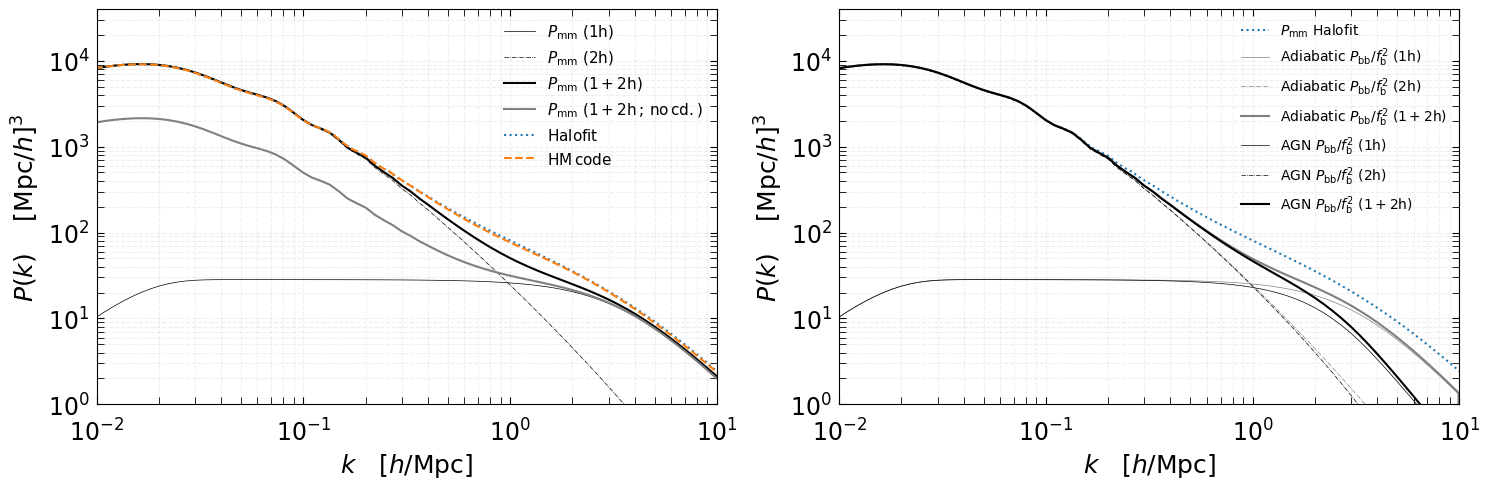

In [6]:
k_arr = np.geomspace(2e-3,1e1,100)

label_size = 17
title_size = 18
legend_size = 13
handle_length = 1.5
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))

z_arr = np.linspace(1e-8,4.,1000)
ax = ax1
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')
ax.set_ylabel(r"$P(k)$    $[\mathrm{Mpc}/h]^3$",size=title_size)
ax.set_xlabel(r"$k$   $[h/\mathrm{Mpc}]$",size=title_size)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e0,4e4)
ax.set_xlim(1e-2,1e1)

ax.plot(pk_at_z_hm['k'],pk_at_z_hm['1h'],label = '$P_\mathrm{mm}$ $\mathrm{(1h)}$',c='k',ls='-',lw=0.5)
ax.plot(pk_at_z_hm['k'],pk_at_z_hm['2h'],label = '$P_\mathrm{mm}$ $\mathrm{(2h)}$',c='k',ls='-.',lw=0.5)
ax.plot(pk_at_z_hm['k'],np.asarray(pk_at_z_hm['2h'])+np.asarray(pk_at_z_hm['1h']),label = '$P_\mathrm{mm}$ $\mathrm{(1+2h)}$',c='k',ls='-')

ax.plot(pk_at_z_hm_no_consistency['k'],np.asarray(pk_at_z_hm_no_consistency['2h'])+np.asarray(pk_at_z_hm_no_consistency['1h']),label = '$P_\mathrm{mm}$ $\mathrm{(1+2h\,;\,no\,cd.)}$',c='grey',ls='-')

ax.plot(k_arr/M.h(),pk_at_z_class_halofit(k_arr,z_for_pk_hm)*M.h()**3.,label='$\mathrm{Halofit}$',ls=':')
ax.plot(k_arr/M.h(),pk_at_z_class_hmcode(k_arr,z_for_pk_hm)*M.h()**3.,label='$\mathrm{HM\,code}$',ls='--')


ax.legend(fontsize=11,ncol=1,frameon=False)




ax = ax2
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')
ax.set_ylabel(r"$P(k)$    $[\mathrm{Mpc}/h]^3$",size=title_size)
ax.set_xlabel(r"$k$   $[h/\mathrm{Mpc}]$",size=title_size)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e0,4e4)
ax.set_xlim(1e-2,1e1)


ax.plot(k_arr/M.h(),pk_at_z_class_halofit(k_arr,z_for_pk_hm)*M.h()**3.,label='$P_\mathrm{mm}$ $\mathrm{Halofit}$',ls=':')

ax.plot(pk_bb_at_z_hm_shock['k'],np.asarray(pk_bb_at_z_hm_shock['1h'])*M.get_f_b()**-2.,label = '$\mathrm{Adiabatic}$ $P_\mathrm{bb}/f_\mathrm{b}^2$ $\mathrm{(1h)}$',c='grey',ls='-',lw=0.5)
ax.plot(pk_bb_at_z_hm_shock['k'],np.asarray(pk_bb_at_z_hm_shock['2h'])*M.get_f_b()**-2.,label = '$\mathrm{Adiabatic}$ $P_\mathrm{bb}/f_\mathrm{b}^2$ $\mathrm{(2h)}$',c='grey',ls='-.',lw=0.5)

ax.plot(pk_bb_at_z_hm_shock['k'],(np.asarray(pk_bb_at_z_hm_shock['1h'])+np.asarray(pk_bb_at_z_hm_shock['2h']))*M.get_f_b()**-2.,label = '$\mathrm{Adiabatic}$ $P_\mathrm{bb}/f_\mathrm{b}^2$ $\mathrm{(1+2h)}$',c='grey',ls='-')



ax.plot(pk_bb_at_z_hm_agn['k'],np.asarray(pk_bb_at_z_hm_agn['1h'])*M.get_f_b()**-2.,label = '$\mathrm{AGN}$ $P_\mathrm{bb}/f_\mathrm{b}^2$ $\mathrm{(1h)}$',c='k',ls='-',lw=0.5)
ax.plot(pk_bb_at_z_hm_agn['k'],np.asarray(pk_bb_at_z_hm_agn['2h'])*M.get_f_b()**-2.,label = '$\mathrm{AGN}$ $P_\mathrm{bb}/f_\mathrm{b}^2$ $\mathrm{(2h)}$',c='k',ls='-.',lw=0.5)
ax.plot(pk_bb_at_z_hm_agn['k'],(np.asarray(pk_bb_at_z_hm_agn['1h'])+np.asarray(pk_bb_at_z_hm_agn['2h']))*M.get_f_b()**-2.,label = '$\mathrm{AGN}$ $P_\mathrm{bb}/f_\mathrm{b}^2$ $\mathrm{(1+2h)}$',c='k',ls='-')




ax.legend(fontsize=10,ncol=1,frameon=False)

fig.tight_layout()

## The 2-halo term of the density profile

In [6]:
# pick a mass and a redshift
m = 3e13*cosmo_params['H0']/100. # amodeo: 3e13 Msun
z = 0.55 # amodeo: z=0.55

In [7]:
%%time

z_for_pk_hm = z
M = Class()
# M.set(ksz_params)
M.set(common_params)
M.set(cosmo_params)
M.set({

'output': 'mPk,pk_b_at_z_2h',
'gas profile':'B16',
'gas profile mode' : 'agn',

    
'M_min' : 1.0e10, 
'M_max' : 5e15,

'x_out_truncated_density_profile (electrons)': 1., 
'normalize_gas_density_profile' : 0,
'use_xout_in_density_profile_from_enclosed_mass' : 1,
    
'non_linear':'hmcode',
"dlnk_for_pk_hm" : 0.1,
"z_for_pk_hm" : z_for_pk_hm,
"z_pk" : z_for_pk_hm ,
"k_min_for_pk_hm" : 1e-2,
"k_max_for_pk_hm" : 1e2,
    
    
'n_k_density_profile' :50,
'n_m_density_profile' :20, # default: 100, decrease for faster
'n_z_density_profile' :50, # default: 100, decrease for faster

'k_min_gas_density_profile' : 1e-3,
'k_max_gas_density_profile' : 1e1, 
    
'k_min_samp_fftw' : 1e-3,
'k_max_samp_fftw' : 1e3,
'N_samp_fftw' : 200,
    
    
'hm_consistency' : 0,
})
M.compute()

CPU times: user 29.9 s, sys: 115 ms, total: 30 s
Wall time: 3.83 s


In [12]:
%%time 
# using mcfit from yin li.

from mcfit import P2xi 

k, pk2h = np.asarray(M.pk_b_at_z_2h()['k']),np.asarray(M.pk_b_at_z_2h()['2h']) ## this is only computed at z_for_pk_hm

num = M.get_nu_at_z_and_m(z,m)
bm = M.get_first_order_bias_at_z_and_nu(z,num)




k, P = k, pk2h
r, xi = P2xi(k)(P)
rho2h = bm*xi

CPU times: user 3.21 ms, sys: 2.71 ms, total: 5.92 ms
Wall time: 4.13 ms


In [13]:
r200c = M.get_r_delta_of_m_delta_at_z(200,m,z)
x_200c = r/r200c
m200c = m


In [14]:
A_rho0 = 4.e3
A_alpha = 0.88
A_beta = 3.83

alpha_m_rho0 = 0.29
alpha_m_alpha = -0.03
alpha_m_beta = 0.04

alpha_z_rho0 = -0.66
alpha_z_alpha = 0.19
alpha_z_beta = -0.025
gamma = -0.2
xc = 0.5

rho_gas_b16 = np.vectorize(M.get_gas_profile_at_x_M_z_b16_200c)
rho_norm_b16 = rho_gas_b16(x_200c,
                           m200c,
                           z,
                            A_rho0 = A_rho0,
                            A_alpha = A_alpha,
                            A_beta = A_beta,
                            alpha_m_rho0 = alpha_m_rho0,
                            alpha_m_alpha = alpha_m_alpha,
                            alpha_m_beta = alpha_m_beta,
                            alpha_z_rho0 = alpha_z_rho0,
                            alpha_z_alpha = alpha_z_alpha,
                            alpha_z_beta = alpha_z_beta,
                            gamma=gamma,
                            xc = xc)/M.get_rho_crit_at_z(z)/M.get_f_b()
# ax1.plot(x_200c,rho_norm_b16*x_200c**2, label = r'AGN',ls='-.',c='r',lw=2.)



In [15]:
# using the internal class fft computation:
# this interpolates in z, ao is available at any z
rho2h_internal = np.vectorize(M.get_rho_2h_at_r_and_m_and_z)(r,m,z)

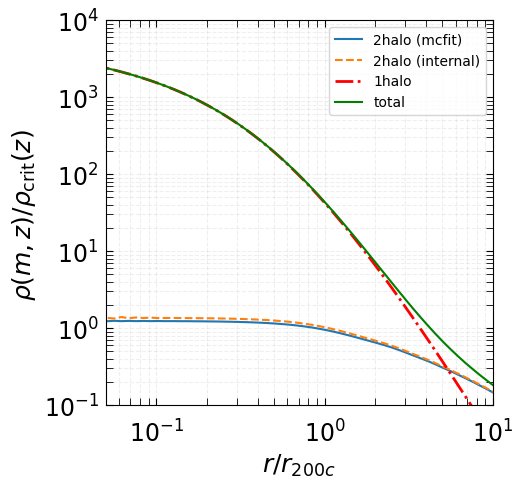

In [16]:

label_size = 17
title_size = 18
legend_size = 13
handle_length = 1.5
fig, (ax1) = plt.subplots(1,1,figsize=(5,5))
ax = ax1
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')
ax.set_ylabel(r"$\rho(m,z)/\rho_\mathrm{crit}(z)$ ",size=title_size)
ax.set_xlabel(r"$r/r_{200c}$",size=title_size)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-1,1e4)
ax.set_xlim(5e-2,1e1)
ax.plot(x_200c,rho2h/M.get_rho_crit_at_z(z)/M.get_f_b(),label='2halo (mcfit)')
ax.plot(x_200c,rho2h_internal/M.get_rho_crit_at_z(z)/M.get_f_b(),label='2halo (internal)',ls='--')
ax.plot(x_200c,rho_norm_b16, label = r'1halo',ls='-.',c='r',lw=2.)
ax.plot(x_200c,rho2h/M.get_rho_crit_at_z(z)/M.get_f_b()+rho_norm_b16,label='total',c='green')
# # plt.xlim(2e-2,4e1)
# plt.ylim(1e-2,1e4)
ax.legend()

## compute for many values of parameters

Here, we assume the cosmology is held fixed. 

In [17]:
%%time

# initialize call 

M = Class()

M.set(common_params)
M.set(cosmo_params)
M.set({

'output': 'gas_density_profile_2h',
'gas profile':'B16',
'gas profile mode' : 'custom', # important to read values of parameters

    
'M_min' : 1.0e10, 
'M_max' : 5e15,

'use_xout_in_density_profile_from_enclosed_mass' : 1,
'n_z_m_to_xout' : 30,
'n_mass_m_to_xout' : 30,
    
'n_k_density_profile' :80,
'n_m_density_profile' :50, # default: 100, decrease for faster
'n_z_density_profile' :50, # default: 100, decrease for faster

'k_min_gas_density_profile' : 1e-3,
'k_max_gas_density_profile' : 1e1, 
    
# 'k_min_samp_fftw' : 1e-4,
# 'k_max_samp_fftw' : 1e3,
# 'N_samp_fftw' : 300,
    
'k_min_samp_fftw' : 1e-3,
'k_max_samp_fftw' : 1e3,
'N_samp_fftw' : 200,
    
'hm_consistency' : 0,

'use_fft_for_profiles_transform' : 1,
'x_min_gas_density_fftw' : 1e-5,
'x_max_gas_density_fftw' : 1e2,
})
M.compute()

CPU times: user 11.7 s, sys: 35.9 ms, total: 11.7 s
Wall time: 1.77 s


In [18]:
# compute on many parameter values, sequentially:
N_params = 10
A_rho0 = np.random.uniform(4.e3-0.5e3, 4.e3+0.5e3, size=(N_params)) # central value: 4e3
A_alpha = np.random.uniform(0.88-0.1, 0.88+0.1, size=(N_params)) # central value: 0.88
A_beta = np.random.uniform(3.83-0.1, 3.83+0.1, size=(N_params)) # central value: 3.83

alpha_m_rho0 = np.repeat(0.29,N_params)
alpha_m_alpha = np.repeat(-0.03,N_params) 
alpha_m_beta = np.repeat(0.04,N_params) 

alpha_z_rho0 = np.repeat(-0.66,N_params) 
alpha_z_alpha = np.repeat(0.19,N_params) 
alpha_z_beta = np.repeat(-0.025,N_params)
gamma = np.repeat(-0.2,N_params)
xc = np.repeat(0.5,N_params)

In [20]:
%%time
ti = time.perf_counter()

rho_1h = []
rho_2h = []


for (A_rho0p,A_alphap,A_betap,
     alpha_m_rho0p,alpha_m_alphap,alpha_m_betap,
     alpha_z_rho0p,alpha_z_alphap,alpha_z_betap,gammap,xcp) \
in zip(A_rho0,A_alpha,A_beta,
     alpha_m_rho0,alpha_m_alpha,alpha_m_beta,
     alpha_z_rho0,alpha_z_alpha,alpha_z_beta,gamma,xc):
    
    class_sz_params_to_update={

        'A_rho0' : A_rho0p,
        'A_alpha' : A_alphap,
        'A_beta' : A_betap,

        'alpha_m_rho0' : alpha_m_rho0p,
        'alpha_m_alpha' : alpha_m_alphap,
        'alpha_m_beta' : alpha_m_betap,

        'alpha_z_rho0' : alpha_z_rho0p,
        'alpha_z_alpha' : alpha_z_alphap,
        'alpha_z_beta' : alpha_z_betap,
        'gamma_B16' : gammap,
        'xc_B16' : xcp,
    }
    
    M.compute_class_sz(class_sz_params_to_update)
    # mass and redshift of interest:
    # (add more blocks if you want more m's and z')
    mp = 3e13*cosmo_params['H0']/100. # in msun/h, 200c definition
    zp = 0.55
    r200c = M.get_r_delta_of_m_delta_at_z(200,mp,zp) # just here for the record, needed for 2-halo
    x_200c = np.geomspace(0.01,30,200) # this is r/r200c
    
    # 1-halo density
    rho_gas_b16 = np.vectorize(M.get_gas_profile_at_x_M_z_b16_200c)
    rho_norm_b16 = rho_gas_b16(x_200c,
                               mp,
                               zp,
                               A_rho0 = A_rho0p,
                               A_alpha = A_alphap,
                               A_beta = A_betap,
                               alpha_m_rho0 = alpha_m_rho0p,
                               alpha_m_alpha = alpha_m_alphap,
                               alpha_m_beta = alpha_m_betap,
                               alpha_z_rho0 = alpha_z_rho0p,
                               alpha_z_alpha = alpha_z_alphap,
                               alpha_z_beta = alpha_z_betap,
                               gamma=gammap,
                               xc = xcp)/M.get_rho_crit_at_z(zp)/M.get_f_b()
    
    rho_1h.append(rho_norm_b16)
    
    # 2-halo contribution
    r = x_200c*r200c
    rho2h_internal = np.vectorize(M.get_rho_2h_at_r_and_m_and_z)(r,mp,zp)
    rho_2h.append(rho2h_internal)
    
tf = time.perf_counter()
print(f"computed in {tf - ti:0.4f} seconds")

computed in 1.1637 seconds
CPU times: user 9.04 s, sys: 49.2 ms, total: 9.09 s
Wall time: 1.16 s


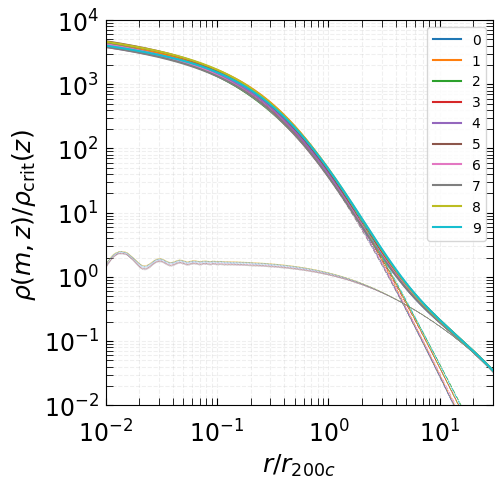

In [60]:

label_size = 17
title_size = 18
legend_size = 13
handle_length = 1.5
fig, (ax1) = plt.subplots(1,1,figsize=(5,5))
ax = ax1
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')
ax.set_ylabel(r"$\rho(m,z)/\rho_\mathrm{crit}(z)$ ",size=title_size)
ax.set_xlabel(r"$r/r_{200c}$",size=title_size)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-2,1e4)
ax.set_xlim(1e-2,3e1)

for ip in range(N_params):
     # be careful here, if you change mass and redshift, the x_200c and zp need to be updated carefully
     p = ax.plot(x_200c,rho_2h[ip]/M.get_rho_crit_at_z(zp)/M.get_f_b(),ls='--',lw=0.2)
     ax.plot(x_200c,rho_1h[ip], ls='-.',lw=0.5,c=p[0].get_color())
     ax.plot(x_200c,rho_2h[ip]/M.get_rho_crit_at_z(zp)/M.get_f_b()+rho_1h[ip],label=str(ip),c=p[0].get_color())
ax.legend()

# Pressure

In [23]:
# pick a mass and a redshift
m = 3e13*cosmo_params['H0']/100. # amodeo: 3e13 Msun
z = 0.55 # amodeo: z=0.55
x =0.5

In [24]:
%%time

z_for_pk_hm = z
M = Class()
# M.set(ksz_params)
M.set(common_params)
M.set(cosmo_params)
M.set({

'output': 'mPk,tSZ_1h,tSZ_2h,pressure_profile_2h',

'pressure profile':'B12',

"ell_min" : 2,
"ell_max" : 8000,

    
'M_min' : 1.0e10, 
'M_max' : 5e15,
    
'non_linear':'hmcode',
"dlnk_for_pk_hm" : 0.05,
"z_for_pk_hm" : z_for_pk_hm,
"z_pk" : z_for_pk_hm ,
"k_min_for_pk_hm" : 1e-3,
"k_max_for_pk_hm" : 1e2,
    
    
'n_k_pressure_profile' :80, # this is l/ls
'n_m_pressure_profile' :50, # default: 100, decrease for faster
'n_z_pressure_profile' :50, # default: 100, decrease for faster

'k_min_gas_pressure_profile' : 1e-3, # 1e-3 l/ls hence no need for very extreme values...
'k_max_gas_pressure_profile' : 1e2, # 1e2

# 'n_k_pressure_profile' :50, # this is kl
'k_min_gas_pressure_profile_2h' : 1e-3, # l/ls hence no need for very extreme values...
'k_max_gas_pressure_profile_2h' : 1e2, 
    
'k_min_samp_fftw' : 1e-3,
'k_max_samp_fftw' : 1e3,
'N_samp_fftw' : 200,
    
    
'hm_consistency' : 0,
    

'use_fft_for_profiles_transform' : 1,
    
# 'k_min_samp_fftw' : 1e-4,
# 'k_max_samp_fftw' : 1e4,
# 'N_samp_fftw' : 500,
    

# 'x_min_gas_pressure_fftw' : 1e-4,
# 'x_max_gas_pressure_fftw' : 1e3,
})
M.compute()

CPU times: user 15.8 s, sys: 33.2 ms, total: 15.8 s
Wall time: 2.18 s


In [25]:
M.get_pressure_P_over_P_delta_at_x_M_z_b12_200c(x,m,z)

0.7937585429796904

In [26]:
l = np.asarray(M.cl_sz()['ell'])
cl_yy_1h = np.asarray(M.cl_sz()['1h'])
cl_yy_2h = np.asarray(M.cl_sz()['2h'])

If things are noisy, then precision params should be cranked up, for instance
pressure_profile_epsabs and pressure_profile_epsrel

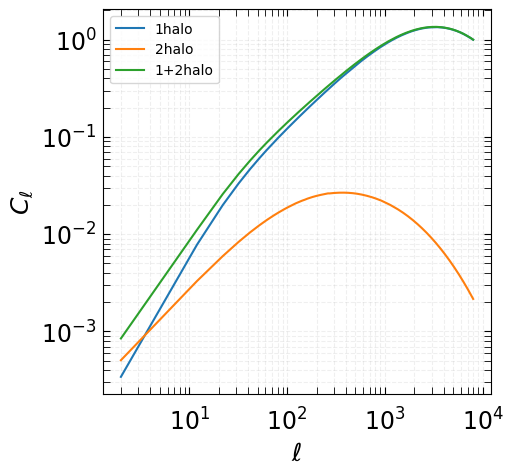

In [27]:
label_size = 17
title_size = 18
legend_size = 13
handle_length = 1.5
fig, (ax1) = plt.subplots(1,1,figsize=(5,5))
ax = ax1
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')
ax.set_xlabel(r"$\ell$ ",size=title_size)
ax.set_ylabel(r"$C_\ell$",size=title_size)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(1e-1,1e4)
# ax.set_xlim(5e-2,1e1)
ax.plot(l,cl_yy_1h,label='1halo')
ax.plot(l,cl_yy_2h,label='2halo')
ax.plot(l,cl_yy_2h+cl_yy_1h,label='1+2halo')
# # plt.xlim(2e-2,4e1)
# plt.ylim(1e-2,1e4)
ax.legend()

In [28]:

r200c = M.get_r_delta_of_m_delta_at_z(200,m,z)
r = np.geomspace(1e-2,1e2,400)
x_200c = r/r200c
m200c = m
# r200c

In [29]:
# using the internal class fft computation:
pe2h_internal = np.vectorize(M.get_gas_pressure_2h_at_r_and_m_and_z)(r,m,z)
pe200 = M.get_P_delta_at_m_and_z_b12(m,z)
# pe200,pe2h_internal

In [30]:
pe = np.vectorize(M.get_pressure_P_over_P_delta_at_x_M_z_b12_200c)(x_200c,m,z)

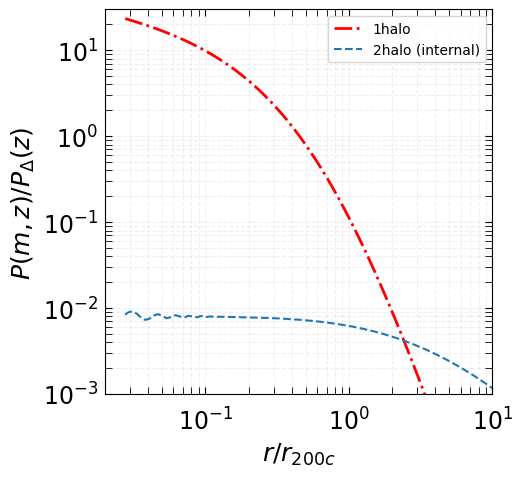

In [31]:
label_size = 17
title_size = 18
legend_size = 13
handle_length = 1.5
fig, (ax1) = plt.subplots(1,1,figsize=(5,5))
ax = ax1
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')
ax.set_ylabel(r"$P(m,z)/P_\Delta(z)$ ",size=title_size)
ax.set_xlabel(r"$r/r_{200c}$",size=title_size)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-3,3e1)
ax.set_xlim(2e-2,1e1)
# ax.plot(x_200c,rho2h,label='2halo (mcfit)')
ax.plot(x_200c,pe, label = r'1halo',ls='-.',c='r',lw=2.)
ax.plot(x_200c,pe2h_internal/pe200,label='2halo (internal)',ls='--')
# # plt.xlim(2e-2,4e1)
# plt.ylim(1e-2,1e4)
ax.legend()

## compute for many values of parameters

Here, we assume the cosmology is held fixed. 

In [6]:
%%time
# initialize call 
M = Class()

M.set(common_params)
M.set(cosmo_params)
M.set({

'output': 'pressure_profile_2h',
'pressure profile':'B12',
    
'M_min' : 1.0e10, 
'M_max' : 5e15,

    
'n_k_pressure_profile' :80, # this is l/ls
'n_m_pressure_profile' :50, # default: 100, decrease for faster
'n_z_pressure_profile' :50, # default: 100, decrease for faster

'k_min_gas_pressure_profile' : 1e-3, # l/ls hence no need for very extreme values...
'k_max_gas_pressure_profile' : 1e2, 

# 'n_k_pressure_profile' :50, # this is kl
'k_min_gas_pressure_profile_2h' : 1e-3, # l/ls hence no need for very extreme values...
'k_max_gas_pressure_profile_2h' : 1e2, 
    
'k_min_samp_fftw' : 1e-3,
'k_max_samp_fftw' : 1e3,
'N_samp_fftw' : 200,
    

'x_min_gas_pressure_fftw' : 1e-5,
'x_max_gas_pressure_fftw' : 1e2,
    
'hm_consistency' : 0,
'use_fft_for_profiles_transform' : 1,
    
    
})    

M.compute()

CPU times: user 11 s, sys: 20.5 ms, total: 11 s
Wall time: 1.5 s


In [8]:
# compute on many parameter values, sequentially:
N_params = 10

P0_B12 = np.random.uniform(18.1 - 2., 18.1 + 2., size=(N_params)) # central value: 4e3
beta_B12 = np.random.uniform(4.35 - 0.3, 4.35 + 0.3, size=(N_params)) # central value: 0.88
alpha_B12 = np.random.uniform(1., 1., size=(N_params)) # central value: 3.83
gamma_B12 = np.repeat(-0.3,N_params)
xc_B12 = np.repeat(0.497,N_params)

alpha_m_P0_B12 = np.repeat(0.154,N_params)
alpha_m_xc_B12 = np.repeat(-0.00865,N_params) 
alpha_m_beta_B12 = np.repeat(0.0393,N_params) 

alpha_z_P0_B12 = np.repeat(-0.758,N_params) 
alpha_z_xc_B12 = np.repeat(0.731,N_params) 
alpha_z_beta_B12 = np.repeat(0.415,N_params)



In [9]:
%%time
ti = time.perf_counter()

pe_1h = []
pe_2h = []


for (P0_B12p,beta_B12p,alpha_B12p,
     alpha_m_P0_B12p,alpha_m_xc_B12p,alpha_m_beta_B12p,
     alpha_z_P0_B12p,alpha_z_xc_B12p,alpha_z_beta_B12p,gamma_B12p,xc_B12p) \
in zip(P0_B12,beta_B12,alpha_B12,
     alpha_m_P0_B12,alpha_m_xc_B12,alpha_m_beta_B12,
     alpha_z_P0_B12,alpha_z_xc_B12,alpha_z_beta_B12,gamma_B12,xc_B12):
    
    class_sz_params_to_update={

       'P0_B12' : P0_B12p,
       'beta_B12' : beta_B12p,
       'alpha_B12' : alpha_B12p,
       'gamma_B12' : gamma_B12p,

       'xc_B12' : xc_B12p,
       

       'alpha_m_P0_B12' : alpha_m_P0_B12p,
       'alpha_m_xc_B12' : alpha_m_xc_B12p,
       'alpha_m_beta_B12' : alpha_m_beta_B12p,

       'alpha_z_P0_B12' : alpha_z_P0_B12p,
       'alpha_z_xc_B12' : alpha_z_xc_B12p,
       'alpha_z_beta_B12' : alpha_z_beta_B12p
    }
    
    M.compute_class_sz(class_sz_params_to_update)
    # mass and redshift of interest:
    # (add more blocks if you want more m's and z')
    mp = 3e13*cosmo_params['h'] # in msun/h, 200c definition
    zp = 0.55
    r200c = M.get_r_delta_of_m_delta_at_z(200,mp,zp) # just here for the record, needed for 2-halo
    x_200c = np.geomspace(0.01,30,200) # this is r/r200c
    
    # 1-halo pressure
    pe = np.vectorize(M.get_pressure_P_over_P_delta_at_x_M_z_b12_200c)
    pe1h = pe(x_200c,
              mp,
              zp,
              A_P0 = P0_B12p,
              A_xc = xc_B12p,
              A_beta = beta_B12p,
              alpha_m_P0 = alpha_m_P0_B12p,
              alpha_m_xc = alpha_m_xc_B12p,
              alpha_m_beta = alpha_m_beta_B12p,
              alpha_z_P0 = alpha_z_P0_B12p,
              alpha_z_xc = alpha_z_xc_B12p,
              alpha_z_beta = alpha_z_beta_B12p,
              alpha = alpha_B12p,
              gamma = gamma_B12p)
    
    pe_1h.append(pe1h)
    
    # 2-halo contribution
    r = x_200c*r200c
    pe2h_internal = np.vectorize(M.get_gas_pressure_2h_at_r_and_m_and_z)(r,mp,zp)
    pe200 = M.get_P_delta_at_m_and_z_b12(mp,zp)
    pe_2h.append(pe2h_internal/pe200)
    
tf = time.perf_counter()
print(f"computed in {tf - ti:0.4f} seconds")

computed in 0.4062 seconds
CPU times: user 2.89 s, sys: 25.5 ms, total: 2.91 s
Wall time: 406 ms


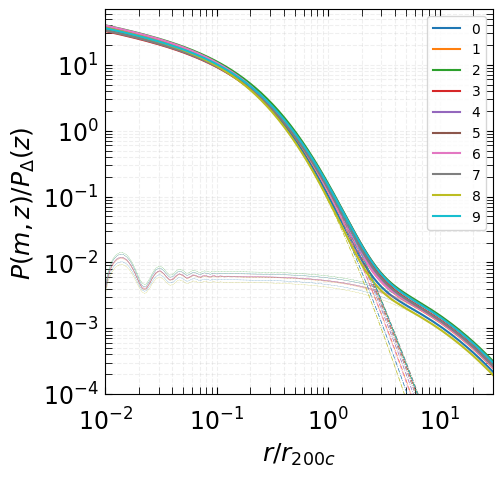

In [10]:
label_size = 17
title_size = 18
legend_size = 13
handle_length = 1.5
fig, (ax1) = plt.subplots(1,1,figsize=(5,5))
ax = ax1
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')
ax.set_ylabel(r"$P(m,z)/P_\Delta(z)$ ",size=title_size)
ax.set_xlabel(r"$r/r_{200c}$",size=title_size)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-4,7e1)
ax.set_xlim(1e-2,3e1)


for ip in range(N_params):
     # be careful here, if you change mass and redshift, the x_200c and zp need to be updated carefully
     p = ax.plot(x_200c,pe_2h[ip],ls='--',lw=0.2)
     ax.plot(x_200c,pe_1h[ip], ls='-.',lw=0.5,c=p[0].get_color())
     ax.plot(x_200c,pe_2h[ip]+pe_1h[ip],label=str(ip),c=p[0].get_color())
ax.legend()


## effect of truncation radius on pressure profile 2-halo term

In [2]:
%%time
# initialize call 
M = Class()

M.set(common_params)
M.set(cosmo_params)
M.set({

'output': 'mPk,pressure_profile_2h',
'pressure profile':'B12',
    
'M_min' : 1.0e10, 
'M_max' : 5e15,

    
'n_k_pressure_profile' :80, # this is l/ls
'n_m_pressure_profile' :50, # default: 100, decrease for faster
'n_z_pressure_profile' :50, # default: 100, decrease for faster

'k_min_gas_pressure_profile' : 1e-3, # l/ls hence no need for very extreme values...
'k_max_gas_pressure_profile' : 1e2, 

'n_k_pressure_profile' :50, # this is kl
'k_min_gas_pressure_profile_2h' : 1e-3, # l/ls hence no need for very extreme values...
'k_max_gas_pressure_profile_2h' : 1e2, 
    
'k_min_samp_fftw' : 1e-3,
'k_max_samp_fftw' : 1e3,
'N_samp_fftw' : 200,
    
'k_min_samp_fftw' : 1e-3,
'k_max_samp_fftw' : 1e3,
'N_samp_fftw' : 200,
    
    
'hm_consistency' : 0,

})    

M.compute()

CPU times: user 18.5 s, sys: 48.2 ms, total: 18.5 s
Wall time: 2.4 s


In [3]:
# compute on many parameter values, sequentially:
N_params = 10


xoutsz = np.linspace(2,12,N_params)

P0_B12 = np.repeat(18.1,N_params) # central value: 4e3
beta_B12 = np.repeat(4.35,N_params) # central value: 0.88
alpha_B12 = np.repeat(1.,N_params) # central value: 3.83
gamma_B12 = np.repeat(-0.3,N_params)
xc_B12 = np.repeat(0.497,N_params)

alpha_m_P0_B12 = np.repeat(0.154,N_params)
alpha_m_xc_B12 = np.repeat(-0.00865,N_params) 
alpha_m_beta_B12 = np.repeat(0.0393,N_params) 

alpha_z_P0_B12 = np.repeat(-0.758,N_params) 
alpha_z_xc_B12 = np.repeat(0.731,N_params) 
alpha_z_beta_B12 = np.repeat(0.415,N_params)



In [4]:
%%time
ti = time.perf_counter()

pe_1h = []
pe_2h = []


for (xoutszp,P0_B12p,beta_B12p,alpha_B12p,
     alpha_m_P0_B12p,alpha_m_xc_B12p,alpha_m_beta_B12p,
     alpha_z_P0_B12p,alpha_z_xc_B12p,alpha_z_beta_B12p,gamma_B12p,xc_B12p) \
in zip(xoutsz,P0_B12,beta_B12,alpha_B12,
     alpha_m_P0_B12,alpha_m_xc_B12,alpha_m_beta_B12,
     alpha_z_P0_B12,alpha_z_xc_B12,alpha_z_beta_B12,gamma_B12,xc_B12):
    
    class_sz_params_to_update={
       'x_outSZ': xoutszp,
       'P0_B12' : P0_B12p,
       'beta_B12' : beta_B12p,
       'alpha_B12' : alpha_B12p,
       'gamma_B12' : gamma_B12p,

       'xc_B12' : xc_B12p,
       

       'alpha_m_P0_B12' : alpha_m_P0_B12p,
       'alpha_m_xc_B12' : alpha_m_xc_B12p,
       'alpha_m_beta_B12' : alpha_m_beta_B12p,

       'alpha_z_P0_B12' : alpha_z_P0_B12p,
       'alpha_z_xc_B12' : alpha_z_xc_B12p,
       'alpha_z_beta_B12' : alpha_z_beta_B12p
    }
    
    M.compute_class_sz(class_sz_params_to_update)
    # mass and redshift of interest:
    # (add more blocks if you want more m's and z')
    mp = 3e13*cosmo_params['h'] # in msun/h, 200c definition
    zp = 0.55
    r200c = M.get_r_delta_of_m_delta_at_z(200,mp,zp) # just here for the record, needed for 2-halo
    x_200c = np.geomspace(0.01,30,200) # this is r/r200c
    
    # 1-halo pressure
    pe = np.vectorize(M.get_pressure_P_over_P_delta_at_x_M_z_b12_200c)
    pe1h = pe(x_200c,
              mp,
              zp,
              A_P0 = P0_B12p,
              A_xc = xc_B12p,
              A_beta = beta_B12p,
              alpha_m_P0 = alpha_m_P0_B12p,
              alpha_m_xc = alpha_m_xc_B12p,
              alpha_m_beta = alpha_m_beta_B12p,
              alpha_z_P0 = alpha_z_P0_B12p,
              alpha_z_xc = alpha_z_xc_B12p,
              alpha_z_beta = alpha_z_beta_B12p,
              alpha = alpha_B12p,
              gamma = gamma_B12p)
    
    pe_1h.append(pe1h)
    
    # 2-halo contribution
    r = x_200c*r200c
    pe2h_internal = np.vectorize(M.get_gas_pressure_2h_at_r_and_m_and_z)(r,mp,zp)
    pe200 = M.get_P_delta_at_m_and_z_b12(mp,zp)
    pe_2h.append(pe2h_internal/pe200)
    
tf = time.perf_counter()
print(f"computed in {tf - ti:0.4f} seconds")

computed in 16.5079 seconds
CPU times: user 2min 23s, sys: 416 ms, total: 2min 23s
Wall time: 16.5 s


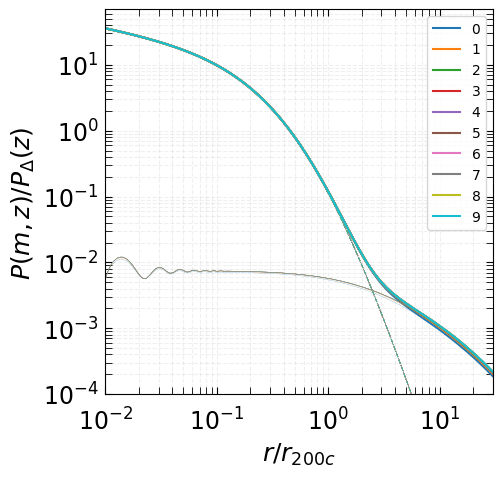

In [5]:
label_size = 17
title_size = 18
legend_size = 13
handle_length = 1.5
fig, (ax1) = plt.subplots(1,1,figsize=(5,5))
ax = ax1
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')
ax.set_ylabel(r"$P(m,z)/P_\Delta(z)$ ",size=title_size)
ax.set_xlabel(r"$r/r_{200c}$",size=title_size)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-4,7e1)
ax.set_xlim(1e-2,3e1)


for ip in range(N_params):
     # be careful here, if you change mass and redshift, the x_200c and zp need to be updated carefully
     p = ax.plot(x_200c,pe_2h[ip],ls='--',lw=0.2)
     ax.plot(x_200c,pe_1h[ip], ls='-.',lw=0.5,c=p[0].get_color())
     ax.plot(x_200c,pe_2h[ip]+pe_1h[ip],label=str(ip),c=p[0].get_color())
ax.legend()

ax.legend()

# Density And Pressure for many parameter values

In [61]:
%%time
# initialize call 
M = Class()

M.set(common_params)
M.set(cosmo_params)
M.set({

'output': 'pressure_profile_2h,gas_density_profile_2h',


'pressure profile':'B12',
'gas profile':'B16',
'gas profile mode' : 'custom', # important to read values of parameters
'use_xout_in_density_profile_from_enclosed_mass' : 1,
'n_z_m_to_xout' : 30,
'n_mass_m_to_xout' : 30,
    
    
'M_min' : 1.0e10, 
'M_max' : 5e15,

    
'n_k_pressure_profile' :80, # this is l/ls
'n_m_pressure_profile' :50, # default: 100, decrease for faster
'n_z_pressure_profile' :50, # default: 100, decrease for faster

'k_min_gas_pressure_profile' : 1e-3, # l/ls hence no need for very extreme values...
'k_max_gas_pressure_profile' : 1e2, 

'k_min_gas_pressure_profile_2h' : 1e-3, # l/ls hence no need for very extreme values...
'k_max_gas_pressure_profile_2h' : 1e2, 
    
    
'n_k_density_profile' :80,
'n_m_density_profile' :50, # default: 100, decrease for faster
'n_z_density_profile' :50, # default: 100, decrease for faster

'k_min_gas_density_profile' : 1e-3,
'k_max_gas_density_profile' : 1e2, 
    
'k_min_samp_fftw' : 1e-3,
'k_max_samp_fftw' : 1e3,
'N_samp_fftw' : 200,
    
    
'hm_consistency' : 0,
    
    
'use_fft_for_profiles_transform' : 1,
    
    
'x_min_gas_density_fftw' : 1e-5,
'x_max_gas_density_fftw' : 1e2,
    
    
'x_min_gas_pressure_fftw' : 1e-5,
'x_max_gas_pressure_fftw' : 1e2,
})    

M.compute_class_szfast()

CPU times: user 1.54 s, sys: 176 ms, total: 1.72 s
Wall time: 526 ms


In [62]:
# compute on many parameter values, sequentially:
N_params = 10

# density profile parameters:
A_rho0 = np.random.uniform(4.e3-0.5e3, 4.e3+0.5e3, size=(N_params)) # central value: 4e3
A_alpha = np.random.uniform(0.88-0.1, 0.88+0.1, size=(N_params)) # central value: 0.88
A_beta = np.random.uniform(3.83-0.1, 3.83+0.1, size=(N_params)) # central value: 3.83

alpha_m_rho0 = np.repeat(0.29,N_params)
alpha_m_alpha = np.repeat(-0.03,N_params) 
alpha_m_beta = np.repeat(0.04,N_params) 

alpha_z_rho0 = np.repeat(-0.66,N_params) 
alpha_z_alpha = np.repeat(0.19,N_params) 
alpha_z_beta = np.repeat(-0.025,N_params)
gamma = np.repeat(-0.2,N_params)
xc = np.repeat(0.5,N_params)


# pressure profile parameters
P0_B12 = np.random.uniform(18.1 - 2., 18.1 + 2., size=(N_params)) # central value: 4e3
beta_B12 = np.random.uniform(4.35 - 0.3, 4.35 + 0.3, size=(N_params)) # central value: 0.88
alpha_B12 = np.random.uniform(1., 1., size=(N_params)) # central value: 3.83
gamma_B12 = np.repeat(-0.3,N_params)
xc_B12 = np.repeat(0.497,N_params)

alpha_m_P0_B12 = np.repeat(0.154,N_params)
alpha_m_xc_B12 = np.repeat(-0.00865,N_params) 
alpha_m_beta_B12 = np.repeat(0.0393,N_params) 

alpha_z_P0_B12 = np.repeat(-0.758,N_params) 
alpha_z_xc_B12 = np.repeat(0.731,N_params) 
alpha_z_beta_B12 = np.repeat(0.415,N_params)

In [63]:
%%time
ti = time.perf_counter()

rho_1h = []
rho_2h = []

pe_1h = []
pe_2h = []


for (P0_B12p,beta_B12p,alpha_B12p,
     alpha_m_P0_B12p,alpha_m_xc_B12p,alpha_m_beta_B12p,
     alpha_z_P0_B12p,alpha_z_xc_B12p,alpha_z_beta_B12p,gamma_B12p,xc_B12p,
     A_rho0p,A_alphap,A_betap,
     alpha_m_rho0p,alpha_m_alphap,alpha_m_betap,
     alpha_z_rho0p,alpha_z_alphap,alpha_z_betap,gammap,xcp) \
in zip(P0_B12,beta_B12,alpha_B12,
     alpha_m_P0_B12,alpha_m_xc_B12,alpha_m_beta_B12,
     alpha_z_P0_B12,alpha_z_xc_B12,alpha_z_beta_B12,gamma_B12,xc_B12,
     A_rho0,A_alpha,A_beta,
     alpha_m_rho0,alpha_m_alpha,alpha_m_beta,
     alpha_z_rho0,alpha_z_alpha,alpha_z_beta,gamma,xc):

    class_sz_params_to_update={

        'A_rho0' : A_rho0p,
        'A_alpha' : A_alphap,
        'A_beta' : A_betap,

        'alpha_m_rho0' : alpha_m_rho0p,
        'alpha_m_alpha' : alpha_m_alphap,
        'alpha_m_beta' : alpha_m_betap,

        'alpha_z_rho0' : alpha_z_rho0p,
        'alpha_z_alpha' : alpha_z_alphap,
        'alpha_z_beta' : alpha_z_betap,
        'gamma_B16' : gammap,
        'xc_B16' : xcp,
        'cp_B16': 0.,
        

        'mcut' : 1.e14,
        'alphap_m_rho0' : alpha_m_rho0p,
        'alphap_m_alpha' : alpha_m_alphap,
        'alphap_m_beta' : alpha_m_betap,

        'alpha_c_rho0' : 0.,
        'alpha_c_alpha' : 0.,
        'alpha_c_beta' : 0.,       
        
        
       'P0_B12' : P0_B12p,
       'beta_B12' : beta_B12p,
       'alpha_B12' : alpha_B12p,
       'gamma_B12' : gamma_B12p,

       'xc_B12' : xc_B12p,
       'mcut_B12' : 1.e14,
       'cp_B12': 0.,
       

       'alpha_m_P0_B12' : alpha_m_P0_B12p,
       'alpha_m_xc_B12' : alpha_m_xc_B12p,
       'alpha_m_beta_B12' : alpha_m_beta_B12p,

        
       'alphap_m_P0_B12' : alpha_m_P0_B12p,
       'alphap_m_xc_B12' : alpha_m_xc_B12p,
       'alphap_m_beta_B12' : alpha_m_beta_B12p,
        
       'alpha_z_P0_B12' : alpha_z_P0_B12p,
       'alpha_z_xc_B12' : alpha_z_xc_B12p,
       'alpha_z_beta_B12' : alpha_z_beta_B12p,
    }
    
    M.compute_class_sz(class_sz_params_to_update)
    # mass and redshift of interest:
    # (add more blocks if you want more m's and z')
    mp = 3e13*cosmo_params['H0']/100. # in msun/h, 200c definition
    zp = 0.55
    r200c = M.get_r_delta_of_m_delta_at_z(200,mp,zp) # just here for the record, needed for 2-halo
    x_200c = np.geomspace(0.01,30,200) # this is r/r200c
    
    # 1-halo density
    rho_gas_b16 = np.vectorize(M.get_gas_profile_at_x_M_z_b16_200c)
    rho_norm_b16 = rho_gas_b16(x_200c,
                               mp,
                               zp,
                               # cp = 0.,
                               A_rho0 = A_rho0p,
                               A_alpha = A_alphap,
                               A_beta = A_betap,
                               alpha_m_rho0 = alpha_m_rho0p,
                               alpha_m_alpha = alpha_m_alphap,
                               alpha_m_beta = alpha_m_betap,
                               alpha_z_rho0 = alpha_z_rho0p,
                               alpha_z_alpha = alpha_z_alphap,
                               alpha_z_beta = alpha_z_betap,
                               gamma=gammap,
                               xc = xcp)/M.get_rho_crit_at_z(zp)/M.get_f_b()
    
    rho_1h.append(rho_norm_b16)
    
    # 2-halo contribution
    r = x_200c*r200c
    rho2h_internal = np.vectorize(M.get_rho_2h_at_r_and_m_and_z)(r,mp,zp)
    rho_2h.append(rho2h_internal)

    
    # 1-halo pressure
    pe = np.vectorize(M.get_pressure_P_over_P_delta_at_x_M_z_b12_200c)
    pe1h = pe(x_200c,
              mp,
              zp,
              # cp = 0.,
              A_P0 = P0_B12p,
              A_xc = xc_B12p,
              A_beta = beta_B12p,
              alpha_m_P0 = alpha_m_P0_B12p,
              alpha_m_xc = alpha_m_xc_B12p,
              alpha_m_beta = alpha_m_beta_B12p,
              alpha_z_P0 = alpha_z_P0_B12p,
              alpha_z_xc = alpha_z_xc_B12p,
              alpha_z_beta = alpha_z_beta_B12p,
              alpha = alpha_B12p,
              gamma = gamma_B12p)
    
    pe_1h.append(pe1h)
    
    # 2-halo contribution
    pe2h_internal = np.vectorize(M.get_gas_pressure_2h_at_r_and_m_and_z)(r,mp,zp)
    pe200 = M.get_P_delta_at_m_and_z_b12(mp,zp)
    pe_2h.append(pe2h_internal/pe200)
    
tf = time.perf_counter()
print(f"computed in {tf - ti:0.4f} seconds")

computed in 1.4509 seconds
CPU times: user 11.4 s, sys: 55.9 ms, total: 11.5 s
Wall time: 1.45 s


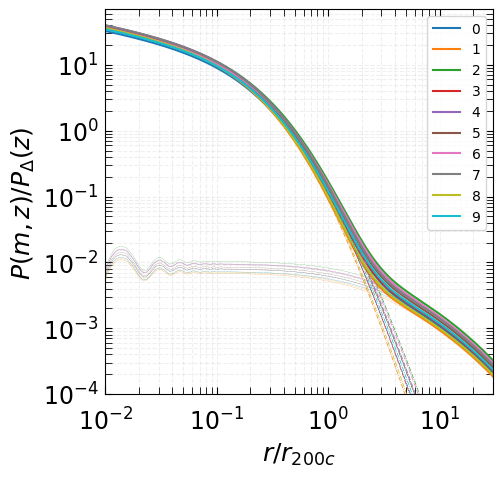

In [64]:
label_size = 17
title_size = 18
legend_size = 13
handle_length = 1.5
fig, (ax1) = plt.subplots(1,1,figsize=(5,5))
ax = ax1
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')
ax.set_ylabel(r"$P(m,z)/P_\Delta(z)$ ",size=title_size)
ax.set_xlabel(r"$r/r_{200c}$",size=title_size)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-4,7e1)
ax.set_xlim(1e-2,3e1)


for ip in range(N_params):
     # be careful here, if you change mass and redshift, the x_200c and zp need to be updated carefully
     p = ax.plot(x_200c,pe_2h[ip],ls='--',lw=0.2)
     ax.plot(x_200c,pe_1h[ip], ls='-.',lw=0.5,c=p[0].get_color())
     ax.plot(x_200c,pe_2h[ip]+pe_1h[ip],label=str(ip),c=p[0].get_color())
ax.legend()


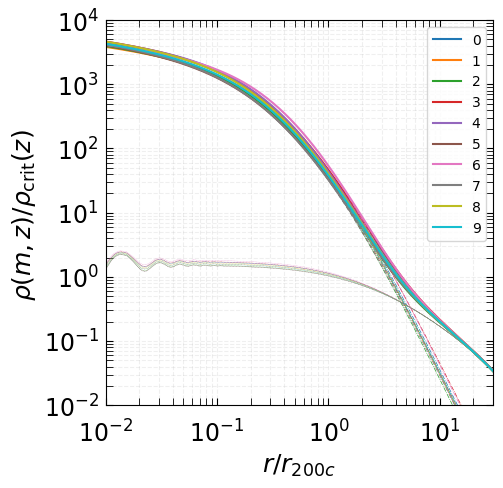

In [65]:

label_size = 17
title_size = 18
legend_size = 13
handle_length = 1.5
fig, (ax1) = plt.subplots(1,1,figsize=(5,5))
ax = ax1
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')
ax.set_ylabel(r"$\rho(m,z)/\rho_\mathrm{crit}(z)$ ",size=title_size)
ax.set_xlabel(r"$r/r_{200c}$",size=title_size)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-2,1e4)
ax.set_xlim(1e-2,3e1)

for ip in range(N_params):
     # be careful here, if you change mass and redshift, the x_200c and zp need to be updated carefully
     p = ax.plot(x_200c,rho_2h[ip]/M.get_rho_crit_at_z(zp)/M.get_f_b(),ls='--',lw=0.2)
     ax.plot(x_200c,rho_1h[ip], ls='-.',lw=0.5,c=p[0].get_color())
     ax.plot(x_200c,rho_2h[ip]/M.get_rho_crit_at_z(zp)/M.get_f_b()+rho_1h[ip],label=str(ip),c=p[0].get_color())
ax.legend()

# Effect of halo model consistency conditions

In [66]:

rho_1h = []
rho_2h = []

pe_1h = []
pe_2h = []

In [39]:
%%time
# initialize call 
M = Class()

M.set(common_params)
M.set(cosmo_params)
M.set({

'output': 'pressure_profile_2h,gas_density_profile_2h',


'pressure profile':'B12',
'gas profile':'B16',
'gas profile mode' : 'custom', # important to read values of parameters
'use_xout_in_density_profile_from_enclosed_mass' : 1,
'n_z_m_to_xout' : 30,
'n_mass_m_to_xout' : 30,
    
    
'M_min' : 1.0e10, 
'M_max' : 5e15,

    
'n_k_pressure_profile' :80, # this is l/ls
'n_m_pressure_profile' :50, # default: 100, decrease for faster
'n_z_pressure_profile' :50, # default: 100, decrease for faster

'k_min_gas_pressure_profile' : 1e-3, # l/ls hence no need for very extreme values...
'k_max_gas_pressure_profile' : 1e2, 

'k_min_gas_pressure_profile_2h' : 1e-3, # l/ls hence no need for very extreme values...
'k_max_gas_pressure_profile_2h' : 1e2, 
    
    
'n_k_density_profile' :80,
'n_m_density_profile' :50, # default: 100, decrease for faster
'n_z_density_profile' :50, # default: 100, decrease for faster

'k_min_gas_density_profile' : 1e-3,
'k_max_gas_density_profile' : 1e2, 
    
'k_min_samp_fftw' : 1e-3,
'k_max_samp_fftw' : 1e3,
'N_samp_fftw' : 200,
    
    
'hm_consistency' : 0,
    
    
'use_fft_for_profiles_transform' : 1,
    
    
'x_min_gas_density_fftw' : 1e-5,
'x_max_gas_density_fftw' : 1e2,
    
    
'x_min_gas_pressure_fftw' : 1e-5,
'x_max_gas_pressure_fftw' : 1e2,
})    

M.compute_class_szfast()

CPU times: user 1.55 s, sys: 155 ms, total: 1.7 s
Wall time: 487 ms


In [40]:
mp = 3e13*cosmo_params['H0']/100. # in msun/h, 200c definition
zp = 0.55
r200c = M.get_r_delta_of_m_delta_at_z(200,mp,zp) # just here for the record, needed for 2-halo
x_200c = np.geomspace(0.01,30,200) # this is r/r200c

# 1-halo density
rho_gas_b16 = np.vectorize(M.get_gas_profile_at_x_M_z_b16_200c)
rho_norm_b16 = rho_gas_b16(x_200c,
                           mp,
                           zp,
                           A_rho0 = A_rho0p,
                           A_alpha = A_alphap,
                           A_beta = A_betap,
                           alpha_m_rho0 = alpha_m_rho0p,
                           alpha_m_alpha = alpha_m_alphap,
                           alpha_m_beta = alpha_m_betap,
                           alpha_z_rho0 = alpha_z_rho0p,
                           alpha_z_alpha = alpha_z_alphap,
                           alpha_z_beta = alpha_z_betap,
                           gamma=gammap,
                           xc = xcp)/M.get_rho_crit_at_z(zp)/M.get_f_b()

rho_1h.append(rho_norm_b16)

# 2-halo contribution
r = x_200c*r200c
rho2h_internal = np.vectorize(M.get_rho_2h_at_r_and_m_and_z)(r,mp,zp)
rho_2h.append(rho2h_internal)


# 1-halo pressure
pe = np.vectorize(M.get_pressure_P_over_P_delta_at_x_M_z_b12_200c)
pe1h = pe(x_200c,
          mp,
          zp,
          A_P0 = P0_B12p,
          A_xc = xc_B12p,
          A_beta = beta_B12p,
          alpha_m_P0 = alpha_m_P0_B12p,
          alpha_m_xc = alpha_m_xc_B12p,
          alpha_m_beta = alpha_m_beta_B12p,
          alpha_z_P0 = alpha_z_P0_B12p,
          alpha_z_xc = alpha_z_xc_B12p,
          alpha_z_beta = alpha_z_beta_B12p,
          alpha = alpha_B12p,
          gamma = gamma_B12p)

pe_1h.append(pe1h)

# 2-halo contribution
pe2h_internal = np.vectorize(M.get_gas_pressure_2h_at_r_and_m_and_z)(r,mp,zp)
pe200 = M.get_P_delta_at_m_and_z_b12(mp,zp)
pe_2h.append(pe2h_internal/pe200)

In [41]:
%%time
# initialize call 
M = Class()

M.set(common_params)
M.set(cosmo_params)
M.set({

'output': 'pressure_profile_2h,gas_density_profile_2h',


'pressure profile':'B12',
'gas profile':'B16',
'gas profile mode' : 'custom', # important to read values of parameters
'use_xout_in_density_profile_from_enclosed_mass' : 1,
'n_z_m_to_xout' : 30,
'n_mass_m_to_xout' : 30,
    
    
'M_min' : 1.0e10, 
'M_max' : 5e15,

    
'n_k_pressure_profile' :80, # this is l/ls
'n_m_pressure_profile' :50, # default: 100, decrease for faster
'n_z_pressure_profile' :50, # default: 100, decrease for faster

'k_min_gas_pressure_profile' : 1e-3, # l/ls hence no need for very extreme values...
'k_max_gas_pressure_profile' : 1e2, 

'k_min_gas_pressure_profile_2h' : 1e-3, # l/ls hence no need for very extreme values...
'k_max_gas_pressure_profile_2h' : 1e2, 
    
    
'n_k_density_profile' :80,
'n_m_density_profile' :50, # default: 100, decrease for faster
'n_z_density_profile' :50, # default: 100, decrease for faster

'k_min_gas_density_profile' : 1e-3,
'k_max_gas_density_profile' : 1e2, 
    
'k_min_samp_fftw' : 1e-3,
'k_max_samp_fftw' : 1e3,
'N_samp_fftw' : 200,
    
    
'hm_consistency' : 1,
    
    
'use_fft_for_profiles_transform' : 1,
    
    
'x_min_gas_density_fftw' : 1e-5,
'x_max_gas_density_fftw' : 1e2,
    
    
'x_min_gas_pressure_fftw' : 1e-5,
'x_max_gas_pressure_fftw' : 1e2,
})    

M.compute_class_szfast()

CPU times: user 1.58 s, sys: 156 ms, total: 1.74 s
Wall time: 509 ms


In [42]:
mp = 3e13*cosmo_params['H0']/100. # in msun/h, 200c definition
zp = 0.55
r200c = M.get_r_delta_of_m_delta_at_z(200,mp,zp) # just here for the record, needed for 2-halo
x_200c = np.geomspace(0.01,30,200) # this is r/r200c

# 1-halo density
rho_gas_b16 = np.vectorize(M.get_gas_profile_at_x_M_z_b16_200c)
rho_norm_b16 = rho_gas_b16(x_200c,
                           mp,
                           zp,
                           A_rho0 = A_rho0p,
                           A_alpha = A_alphap,
                           A_beta = A_betap,
                           alpha_m_rho0 = alpha_m_rho0p,
                           alpha_m_alpha = alpha_m_alphap,
                           alpha_m_beta = alpha_m_betap,
                           alpha_z_rho0 = alpha_z_rho0p,
                           alpha_z_alpha = alpha_z_alphap,
                           alpha_z_beta = alpha_z_betap,
                           gamma=gammap,
                           xc = xcp)/M.get_rho_crit_at_z(zp)/M.get_f_b()

rho_1h.append(rho_norm_b16)

# 2-halo contribution
r = x_200c*r200c
rho2h_internal = np.vectorize(M.get_rho_2h_at_r_and_m_and_z)(r,mp,zp)
rho_2h.append(rho2h_internal)


# 1-halo pressure
pe = np.vectorize(M.get_pressure_P_over_P_delta_at_x_M_z_b12_200c)
pe1h = pe(x_200c,
          mp,
          zp,
          A_P0 = P0_B12p,
          A_xc = xc_B12p,
          A_beta = beta_B12p,
          alpha_m_P0 = alpha_m_P0_B12p,
          alpha_m_xc = alpha_m_xc_B12p,
          alpha_m_beta = alpha_m_beta_B12p,
          alpha_z_P0 = alpha_z_P0_B12p,
          alpha_z_xc = alpha_z_xc_B12p,
          alpha_z_beta = alpha_z_beta_B12p,
          alpha = alpha_B12p,
          gamma = gamma_B12p)

pe_1h.append(pe1h)

# 2-halo contribution
pe2h_internal = np.vectorize(M.get_gas_pressure_2h_at_r_and_m_and_z)(r,mp,zp)
pe200 = M.get_P_delta_at_m_and_z_b12(mp,zp)
pe_2h.append(pe2h_internal/pe200)

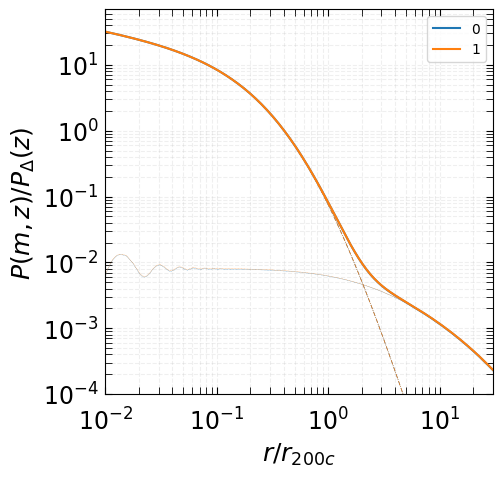

In [43]:
N_params  = 2
label_size = 17
title_size = 18
legend_size = 13
handle_length = 1.5
fig, (ax1) = plt.subplots(1,1,figsize=(5,5))
ax = ax1
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')
ax.set_ylabel(r"$P(m,z)/P_\Delta(z)$ ",size=title_size)
ax.set_xlabel(r"$r/r_{200c}$",size=title_size)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-4,7e1)
ax.set_xlim(1e-2,3e1)


for ip in range(N_params):
     # be careful here, if you change mass and redshift, the x_200c and zp need to be updated carefully
     p = ax.plot(x_200c,pe_2h[ip],ls='--',lw=0.2)
     ax.plot(x_200c,pe_1h[ip], ls='-.',lw=0.5,c=p[0].get_color())
     ax.plot(x_200c,pe_2h[ip]+pe_1h[ip],label=str(ip),c=p[0].get_color())
ax.legend()


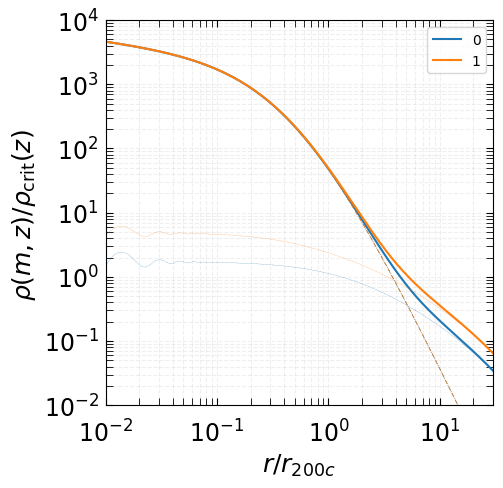

In [44]:
N_params = 2
label_size = 17
title_size = 18
legend_size = 13
handle_length = 1.5
fig, (ax1) = plt.subplots(1,1,figsize=(5,5))
ax = ax1
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')
ax.set_ylabel(r"$\rho(m,z)/\rho_\mathrm{crit}(z)$ ",size=title_size)
ax.set_xlabel(r"$r/r_{200c}$",size=title_size)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-2,1e4)
ax.set_xlim(1e-2,3e1)

for ip in range(N_params):
     # be careful here, if you change mass and redshift, the x_200c and zp need to be updated carefully
     p = ax.plot(x_200c,rho_2h[ip]/M.get_rho_crit_at_z(zp)/M.get_f_b(),ls='--',lw=0.2)
     ax.plot(x_200c,rho_1h[ip], ls='-.',lw=0.5,c=p[0].get_color())
     ax.plot(x_200c,rho_2h[ip]/M.get_rho_crit_at_z(zp)/M.get_f_b()+rho_1h[ip],label=str(ip),c=p[0].get_color())
ax.legend()

# Density And Pressure for many parameter values and 4 concentrations

In [81]:
%%time
# initialize call 
M = Class()

M.set(common_params)
M.set(cosmo_params)
M.set({

'output': 'pressure_profile_2h,gas_density_profile_2h',


'pressure profile':'B12',
'gas profile':'B16',
'gas profile mode' : 'custom', # important to read values of parameters
'use_xout_in_density_profile_from_enclosed_mass' : 1,
'n_z_m_to_xout' : 30,
'n_mass_m_to_xout' : 30,
    
    
'M_min' : 1.0e10, 
'M_max' : 5e15,

    
'n_k_pressure_profile' :50, # this is l/ls # default 80
'n_m_pressure_profile' :30, # default: 100, decrease for faster
'n_z_pressure_profile' :30, # default: 100, decrease for faster

'k_min_gas_pressure_profile' : 1e-3, # l/ls hence no need for very extreme values...
'k_max_gas_pressure_profile' : 1e2, 

'k_min_gas_pressure_profile_2h' : 1e-3, # l/ls hence no need for very extreme values...
'k_max_gas_pressure_profile_2h' : 1e2, 
    
    
'n_k_density_profile' :50, # default 80
'n_m_density_profile' :30, # default: 100, decrease for faster
'n_z_density_profile' :30, # default: 100, decrease for faster

'k_min_gas_density_profile' : 1e-3,
'k_max_gas_density_profile' : 1e2, 
    
'k_min_samp_fftw' : 1e-3,
'k_max_samp_fftw' : 1e3,
'N_samp_fftw' : 200,
    
    
'hm_consistency' : 0,
    
    
'use_fft_for_profiles_transform' : 1,
    
    
'x_min_gas_density_fftw' : 1e-5,
'x_max_gas_density_fftw' : 1e2,
    
    
'x_min_gas_pressure_fftw' : 1e-5,
'x_max_gas_pressure_fftw' : 1e2,
})    

M.compute_class_szfast()

CPU times: user 836 ms, sys: 223 ms, total: 1.06 s
Wall time: 554 ms


In [82]:
# compute on many parameter values, sequentially:
N_params = 10

# density profile parameters:
A_rho0 = np.random.uniform(4.e3-0.5e3, 4.e3+0.5e3, size=(N_params)) # central value: 4e3
A_alpha = np.random.uniform(0.88-0.1, 0.88+0.1, size=(N_params)) # central value: 0.88
A_beta = np.random.uniform(3.83-0.1, 3.83+0.1, size=(N_params)) # central value: 3.83

alpha_m_rho0 = np.repeat(0.29,N_params)
alpha_m_alpha = np.repeat(-0.03,N_params) 
alpha_m_beta = np.repeat(0.04,N_params) 

alpha_z_rho0 = np.repeat(-0.66,N_params) 
alpha_z_alpha = np.repeat(0.19,N_params) 
alpha_z_beta = np.repeat(-0.025,N_params)
gamma = np.repeat(-0.2,N_params)
xc = np.repeat(0.5,N_params)


# pressure profile parameters
P0_B12 = np.random.uniform(18.1 - 2., 18.1 + 2., size=(N_params)) # central value: 4e3
beta_B12 = np.random.uniform(4.35 - 0.3, 4.35 + 0.3, size=(N_params)) # central value: 0.88
alpha_B12 = np.random.uniform(1., 1., size=(N_params)) # central value: 3.83
gamma_B12 = np.repeat(-0.3,N_params)
xc_B12 = np.repeat(0.497,N_params)

alpha_m_P0_B12 = np.repeat(0.154,N_params)
alpha_m_xc_B12 = np.repeat(-0.00865,N_params) 
alpha_m_beta_B12 = np.repeat(0.0393,N_params) 

alpha_z_P0_B12 = np.repeat(-0.758,N_params) 
alpha_z_xc_B12 = np.repeat(0.731,N_params) 
alpha_z_beta_B12 = np.repeat(0.415,N_params)

In [83]:
concentrations_array = np.asarray([0.,1.,2.,3.,4.])
for ic,c in enumerate(concentrations_array):
    print(ic,c)

0 0.0
1 1.0
2 2.0
3 3.0
4 4.0


In [84]:
%%time
ti = time.perf_counter()



rho_1h_all = {}
rho_2h_all = {}

pe_1h_all = {}
pe_2h_all = {}

concentrations_array = np.asarray([0.,1.,2.,3.,4.])

rho_1h = []
rho_2h = []

pe_1h = []
pe_2h = []




for (P0_B12p,beta_B12p,alpha_B12p,
     alpha_m_P0_B12p,alpha_m_xc_B12p,alpha_m_beta_B12p,
     alpha_z_P0_B12p,alpha_z_xc_B12p,alpha_z_beta_B12p,gamma_B12p,xc_B12p,
     A_rho0p,A_alphap,A_betap,
     alpha_m_rho0p,alpha_m_alphap,alpha_m_betap,
     alpha_z_rho0p,alpha_z_alphap,alpha_z_betap,gammap,xcp) \
in zip(P0_B12,beta_B12,alpha_B12,
     alpha_m_P0_B12,alpha_m_xc_B12,alpha_m_beta_B12,
     alpha_z_P0_B12,alpha_z_xc_B12,alpha_z_beta_B12,gamma_B12,xc_B12,
     A_rho0,A_alpha,A_beta,
     alpha_m_rho0,alpha_m_alpha,alpha_m_beta,
     alpha_z_rho0,alpha_z_alpha,alpha_z_beta,gamma,xc):
    
    for ic,c in enumerate(concentrations_array):

        class_sz_params_to_update={

            'cp_B12': c,
            'cp_B16' : c, 

            'A_rho0' : A_rho0p,
            'A_alpha' : A_alphap,
            'A_beta' : A_betap,

            'alpha_m_rho0' : alpha_m_rho0p,
            'alpha_m_alpha' : alpha_m_alphap,
            'alpha_m_beta' : alpha_m_betap,

            'alpha_z_rho0' : alpha_z_rho0p,
            'alpha_z_alpha' : alpha_z_alphap,
            'alpha_z_beta' : alpha_z_betap,
            'gamma_B16' : gammap,
            'xc_B16' : xcp,




           'P0_B12' : P0_B12p,
           'beta_B12' : beta_B12p,
           'alpha_B12' : alpha_B12p,
           'gamma_B12' : gamma_B12p,

           'xc_B12' : xc_B12p,


           'alpha_m_P0_B12' : alpha_m_P0_B12p,
           'alpha_m_xc_B12' : alpha_m_xc_B12p,
           'alpha_m_beta_B12' : alpha_m_beta_B12p,

           'alpha_z_P0_B12' : alpha_z_P0_B12p,
           'alpha_z_xc_B12' : alpha_z_xc_B12p,
           'alpha_z_beta_B12' : alpha_z_beta_B12p,
        }

        M.compute_class_sz(class_sz_params_to_update)
        # mass and redshift of interest:
        # (add more blocks if you want more m's and z')
        mp = 3e13*cosmo_params['H0']/100. # in msun/h, 200c definition
        zp = 0.55
        r200c = M.get_r_delta_of_m_delta_at_z(200,mp,zp) # just here for the record, needed for 2-halo
        x_200c = np.geomspace(0.01,30,200) # this is r/r200c

        # 1-halo density
        rho_gas_b16 = np.vectorize(M.get_gas_profile_at_x_M_z_b16_200c)
        rho_norm_b16 = rho_gas_b16(x_200c,
                                   mp,
                                   zp,
                                   c_asked = c,
                                   A_rho0 = A_rho0p,
                                   A_alpha = A_alphap,
                                   A_beta = A_betap,
                                   alpha_m_rho0 = alpha_m_rho0p,
                                   alpha_m_alpha = alpha_m_alphap,
                                   alpha_m_beta = alpha_m_betap,
                                   alphap_m_rho0 = alpha_m_rho0p,
                                   alphap_m_alpha = alpha_m_alphap,
                                   alphap_m_beta = alpha_m_betap,
                                   alpha_z_rho0 = alpha_z_rho0p,
                                   alpha_z_alpha = alpha_z_alphap,
                                   alpha_z_beta = alpha_z_betap,
                                   gamma=gammap,
                                   xc = xcp)/M.get_rho_crit_at_z(zp)/M.get_f_b()

        rho_1h.append(rho_norm_b16)

        # 2-halo contribution
        r = x_200c*r200c
        rho2h_internal = np.vectorize(M.get_rho_2h_at_r_and_m_and_z)(r,mp,zp)
        rho_2h.append(rho2h_internal)


        # 1-halo pressure
        pe = np.vectorize(M.get_pressure_P_over_P_delta_at_x_M_z_b12_200c)
        pe1h = pe(x_200c,
                  mp,
                  zp,
                  c_asked = c,
                  A_P0 = P0_B12p,
                  A_xc = xc_B12p,
                  A_beta = beta_B12p,
                  alpha_m_P0 = alpha_m_P0_B12p,
                  alpha_m_xc = alpha_m_xc_B12p,
                  alpha_m_beta = alpha_m_beta_B12p,
                  alphap_m_P0 = alpha_m_P0_B12p,
                  alphap_m_xc = alpha_m_xc_B12p,
                  alphap_m_beta = alpha_m_beta_B12p,
                  alpha_z_P0 = alpha_z_P0_B12p,
                  alpha_z_xc = alpha_z_xc_B12p,
                  alpha_z_beta = alpha_z_beta_B12p,
                  alpha = alpha_B12p,
                  gamma = gamma_B12p)

        pe_1h.append(pe1h)

        # 2-halo contribution
        pe2h_internal = np.vectorize(M.get_gas_pressure_2h_at_r_and_m_and_z)(r,mp,zp)
        pe200 = M.get_P_delta_at_m_and_z_b12(mp,zp)
        pe_2h.append(pe2h_internal/pe200)
        
        rho_1h_all[ic] = rho_1h
        rho_2h_all[ic] = rho_2h

        pe_1h_all[ic] = pe_1h
        pe_2h_all[ic] = pe_2h
        
    
tf = time.perf_counter()
print(f"computed in {tf - ti:0.4f} seconds")

computed in 4.0759 seconds
CPU times: user 22.5 s, sys: 171 ms, total: 22.7 s
Wall time: 4.08 s


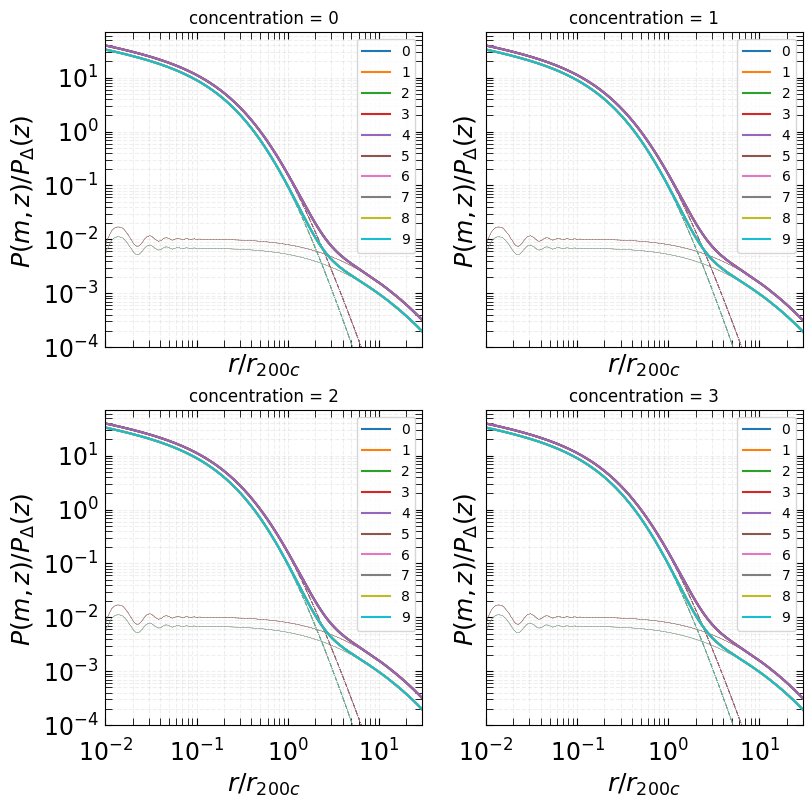

In [85]:
label_size = 17
title_size = 18
legend_size = 13
handle_length = 1.5
plot_dim = 2
# fig, (ax1) = plt.subplots(1,1,figsize=(5,5))
fig, axes = plt.subplots(figsize=(9, 9), sharex=True, 
                         sharey=True, 
                         ncols=plot_dim, 
                         nrows=plot_dim,
                         )
ic = 0
for i in range(plot_dim):
    for j in range(plot_dim):  
        ax = axes[i, j]
        ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
        ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
        ax.xaxis.set_ticks_position('both')
        ax.yaxis.set_ticks_position('both')
        plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
        plt.setp(ax.get_xticklabels(), fontsize=label_size)
        ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')
        ax.set_ylabel(r"$P(m,z)/P_\Delta(z)$ ",size=title_size)
        ax.set_xlabel(r"$r/r_{200c}$",size=title_size)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylim(1e-4,7e1)
        ax.set_xlim(1e-2,3e1)


        for ip in range(N_params):
             # be careful here, if you change mass and redshift, the x_200c and zp need to be updated carefully
             p = ax.plot(x_200c,pe_2h_all[ic][ip],ls='--',lw=0.2)
             ax.plot(x_200c,pe_1h_all[ic][ip], ls='-.',lw=0.5,c=p[0].get_color())
             ax.plot(x_200c,pe_2h_all[ic][ip]+pe_1h_all[ic][ip],label=str(ip),c=p[0].get_color())
        ax.legend()
        ax.set_title('concentration = %d'%ic)
        ic +=1


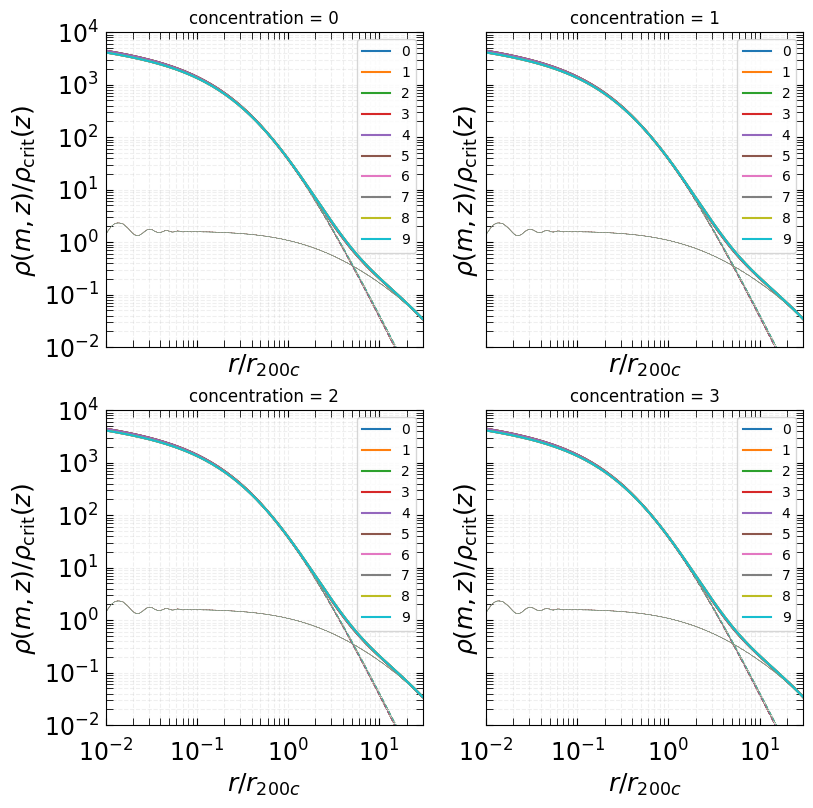

In [86]:

label_size = 17
title_size = 18
legend_size = 13
handle_length = 1.5
plot_dim = 2
# fig, (ax1) = plt.subplots(1,1,figsize=(5,5))
fig, axes = plt.subplots(figsize=(9, 9), sharex=True, 
                         sharey=True, 
                         ncols=plot_dim, 
                         nrows=plot_dim,
                         )
ic = 0
for i in range(plot_dim):
    for j in range(plot_dim): 
        ax = axes[i, j]
        ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
        ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
        ax.xaxis.set_ticks_position('both')
        ax.yaxis.set_ticks_position('both')
        plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
        plt.setp(ax.get_xticklabels(), fontsize=label_size)
        ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')
        ax.set_ylabel(r"$\rho(m,z)/\rho_\mathrm{crit}(z)$ ",size=title_size)
        ax.set_xlabel(r"$r/r_{200c}$",size=title_size)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylim(1e-2,1e4)
        ax.set_xlim(1e-2,3e1)

        for ip in range(N_params):
             # be careful here, if you change mass and redshift, the x_200c and zp need to be updated carefully
             p = ax.plot(x_200c,rho_2h_all[ic][ip]/M.get_rho_crit_at_z(zp)/M.get_f_b(),ls='--',lw=0.2)
             ax.plot(x_200c,rho_1h_all[ic][ip], ls='-.',lw=0.5,c=p[0].get_color())
             ax.plot(x_200c,rho_2h_all[ic][ip]/M.get_rho_crit_at_z(zp)/M.get_f_b()+rho_1h_all[ic][ip],label=str(ip),c=p[0].get_color())
        ax.legend()
        ax.set_title('concentration = %d'%ic)
        ic += 1